In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# Taken from Richard's "Reprod Figure 2"

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/home/ronak/miniconda3/envs/uf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def cef_estimate2(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    estimate = 0.0
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
  
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        estimate += np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))
        
    return estimate / n_estimators

np.warnings.filterwarnings('ignore')

In [5]:
def cef_estimate3(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    estimate = 0.0
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices = np.random.choice(np.arange(len(X)), size=int(np.floor(0.67 * len(X))))
        eval_indices = np.random.choice(np.arange(len(X)), size=int(np.floor(0.67 * len(X))))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        estimate += np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))
    
    return estimate / n_estimators

np.warnings.filterwarnings('ignore')

In [6]:
def cef_estimate4(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    estimate = 0.0
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices = unsampled_indices
        eval_indices = np.arange(len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        estimate += np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))
    
    return estimate / n_estimators

np.warnings.filterwarnings('ignore')

In [7]:
def cef_estimate5(X_, y_, n_estimators = 200, max_samples = 0.5, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    X_train, X_eval, y_train, y_eval = train_test_split(X_, y_, test_size=0.30, random_state=42)
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X_train, y_train)
    class_counts = np.zeros((X_train.shape[0], model.n_classes_))
    eval_class_probs = np.zeros((X_eval.shape[0], model.n_classes_))
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(len(X_train)), sampled_indices)
        
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices = unsampled_indices
        # eval_indices = np.arange(len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X_train[prob_index].reshape(1, -1)).item(), y_train[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        eval_class_probs += [class_probs[x] for x in tree.apply(X_eval)]
    
    eval_class_probs /= n_estimators
    return np.mean(np.nan_to_num(-np.sum(np.log(eval_class_probs)*eval_class_probs, axis = 1)))

np.warnings.filterwarnings('ignore')

In [8]:
# Test the new versions.
# X, y = generate_data(100, 3, mu = 1)

# print(cef_estimate(X, y))
# print(cef_estimate2(X, y))
# print(cef_estimate3(X, y))
# print(cef_estimate4(X, y))
# print(cef_estimate5(X, y))

In [9]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [10]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [11]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [12]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos):
        
    sample_sizes = pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
#     uf = pickle.load(open('uf_by_n_d_%d.pkl' % d, 'rb'))
#     cart = pickle.load(open('cart_by_n_d_%d.pkl' % d, 'rb'))
#     irf = pickle.load(open('irf_by_n_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('uf2_by_n_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('hon_by_n_d_%d.pkl' % d, 'rb'))
#     results = [cart, irf, uf, uf2, hon]
    
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(sample_sizes,
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])
#         # Use transparent lines to show other trials.
#         for t in range(num_plotted_trials):
#             ax.plot(sample_sizes, 
#                     results[j][:, t].flatten(),  
#                     linewidth = 2, 
#                     color = algo['color'],
#                     alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [13]:
def plot_cond_entropy_by_mu(ax, d, n, algos):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

#     uf = pickle.load(open('uf_by_mu_d_%d.pkl' % d, 'rb'))
#     cart = pickle.load(open('cart_by_mu_d_%d.pkl' % d, 'rb'))
#     irf = pickle.load(open('irf_by_mu_d_%d.pkl' % d, 'rb'))
#     uf2 = pickle.load(open('uf2_by_mu_d_%d.pkl' % d, 'rb'))
#     hon = pickle.load(open('hon_by_mu_d_%d.pkl' % d, 'rb'))
#     results = [cart, irf, uf, uf2, hon]
        
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(mus, 
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [14]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2, effect_size, algos)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1, algos)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

In [15]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    # labels = ["CART", "IRF", "UF1", "UF2", "UF3", "UF4", "UF5"]
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [16]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF1":
        return cef_estimate(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF2":
        return cef_estimate2(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF3":
        return cef_estimate3(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF4":
        return cef_estimate4(np.array(X), y, 300, .32, depth = 30)
    elif label == "UF5":
        return cef_estimate4(np.array(X), y, 300, .5, depth = 30)
    else:
        raise ValueError("Unrecognized Label!")

In [17]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    # labels = ["CART", "IRF", "UF1", "UF2", "UF3", "UF4", "UF5"]
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [18]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 40
n1 = 5000
n2 = 10000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(400, 2501, 300)
sample_sizes_d2 = range(400, 10001, 960)

# Fake params.
# mus = [i * 0.5 for i in range(1, 5)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 3
# num_plotted_trials = 3
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF1',
        'title': 'Uncertainty Forest 1',
        'color': "#F41711",
    },
    {
        'label': 'UF2',
        'title': 'Uncertainty Forest 2',
        'color': "purple",
    },
    {
        'label': 'UF3',
        'title': 'Uncertainty Forest 3',
        'color': "blue",
    },
    {
        'label': 'UF4',
        'title': 'Uncertainty Forest 4',
        'color': "m",
    },
    {
        'label': 'UF5',
        'title': 'Uncertainty Forest 5',
        'color': "g",
    },
]

### Estimated H(Y | X) versus n, d = 1

In [19]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.13569144, 0.13313294, 0.16432265, ..., 0.12441931,
         0.07533017, 0.11703523],
        [0.12289864, 0.13428665, 0.13912455, ..., 0.13309493,
         0.14281948, 0.12503092],
        [0.12614034, 0.11174381, 0.14927643, ..., 0.12314648,
         0.12456961, 0.13797705],
        ...,
        [0.10964094, 0.15136413, 0.14048934, ..., 0.14477365,
         0.15226464, 0.13235016],
        [0.14497149, 0.13618479, 0.11365631, ..., 0.13102473,
         0.14353008, 0.14796967],
        [0.12924445, 0.140216  , 0.13444686, ..., 0.13300089,
         0.13034753, 0.13877716]],

       [[0.40827876, 0.44061646, 0.45152378, ..., 0.34239344,
         0.2483636 , 0.4232817 ],
        [0.44056954, 0.42260963, 0.41853665, ..., 0.39260783,
         0.47385302, 0.40761532],
        [0.41563984, 0.38975409, 0.4421358 , ..., 0.43414847,
         0.37517392, 0.45108228],
        ...,
        [0.39436603, 0.44554676, 0.4493837 , ..., 0.44883211,
         0.42054803, 0.42731756],
        [0.4

### Estimated H(Y | X) versus mu, d = 1

In [20]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[4.59370250e-01, 4.43757939e-01, 4.16449036e-01, ...,
         4.42866892e-01, 4.43976074e-01, 4.40882468e-01],
        [1.65868213e-01, 1.68131998e-01, 1.65991018e-01, ...,
         1.60705213e-01, 1.64349504e-01, 1.65445044e-01],
        [5.27027643e-02, 6.18043709e-02, 5.52123457e-02, ...,
         5.53285701e-02, 5.29631389e-02, 5.94849237e-02],
        ...,
        [0.00000000e+00, 1.27581889e-04, 0.00000000e+00, ...,
         4.71311716e-06, 0.00000000e+00, 1.40303365e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.18842224e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[6.46851381e-01, 6.43545946e-01, 6.45589102e-01, ...,
         6.49107296e-01, 6.40598771e-01, 6.48685596e-01],
        [4.52771011e-01, 4.52483174e-01, 4.29217555e-01, ...,
         4.52401152e-01, 4.60111818e-01, 4.28029813e-01],
        [2.22112518e-01, 

### Estimated H(Y | X) versus n, d = 40

In [21]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.20150576, 0.23570251, 0.2022092 , ..., 0.25564173,
         0.22553806, 0.22994714],
        [0.18796819, 0.1577709 , 0.18906285, ..., 0.18243207,
         0.18514582, 0.17643503],
        [0.16401742, 0.18013224, 0.17003668, ..., 0.17401281,
         0.16607974, 0.18140347],
        ...,
        [0.13862634, 0.14118091, 0.14218726, ..., 0.15469186,
         0.132091  , 0.14517017],
        [0.1436443 , 0.14975447, 0.14175526, ..., 0.1444222 ,
         0.13808722, 0.14313531],
        [0.1451117 , 0.14012452, 0.14531596, ..., 0.15122561,
         0.14229922, 0.14118279]],

       [[0.34579339, 0.39033454, 0.28509045, ..., 0.42717233,
         0.30500707, 0.33981617],
        [0.40234077, 0.33747228, 0.37791516, ..., 0.37105525,
         0.37787791, 0.34142153],
        [0.37492997, 0.39649907, 0.37597732, ..., 0.38030979,
         0.36877175, 0.41386809],
        ...,
        [0.35798717, 0.37654495, 0.34652733, ..., 0.37704468,
         0.36634906, 0.39040456],
        [0.3

### Estimated H(Y | X) versus mu, d = 40

In [22]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[3.90598598e-01, 3.26496872e-01, 3.37907935e-01, ...,
         3.30750711e-01, 3.28522197e-01, 3.21232065e-01],
        [1.34834238e-01, 1.49570956e-01, 1.41694038e-01, ...,
         1.42347695e-01, 1.44639665e-01, 1.42321065e-01],
        [5.05074163e-02, 5.44282866e-02, 4.86424114e-02, ...,
         5.18946980e-02, 4.48783598e-02, 5.11936266e-02],
        ...,
        [1.25992166e-03, 9.21090175e-04, 1.18813408e-03, ...,
         1.10915179e-03, 1.10363423e-03, 9.35899926e-04],
        [1.19252024e-03, 9.17062760e-04, 1.04009395e-03, ...,
         1.04727189e-03, 9.64188096e-04, 1.13594076e-03],
        [9.60641651e-04, 9.48291406e-04, 8.76456134e-04, ...,
         9.09655782e-04, 9.43528558e-04, 1.01091719e-03]],

       [[5.91764023e-01, 5.91456997e-01, 5.92893915e-01, ...,
         5.90848930e-01, 5.91516285e-01, 5.91102646e-01],
        [3.66867800e-01, 3.89350220e-01, 3.82603123e-01, ...,
         3.62511060e-01, 3.72501307e-01, 3.82293929e-01],
        [1.65413609e-01, 

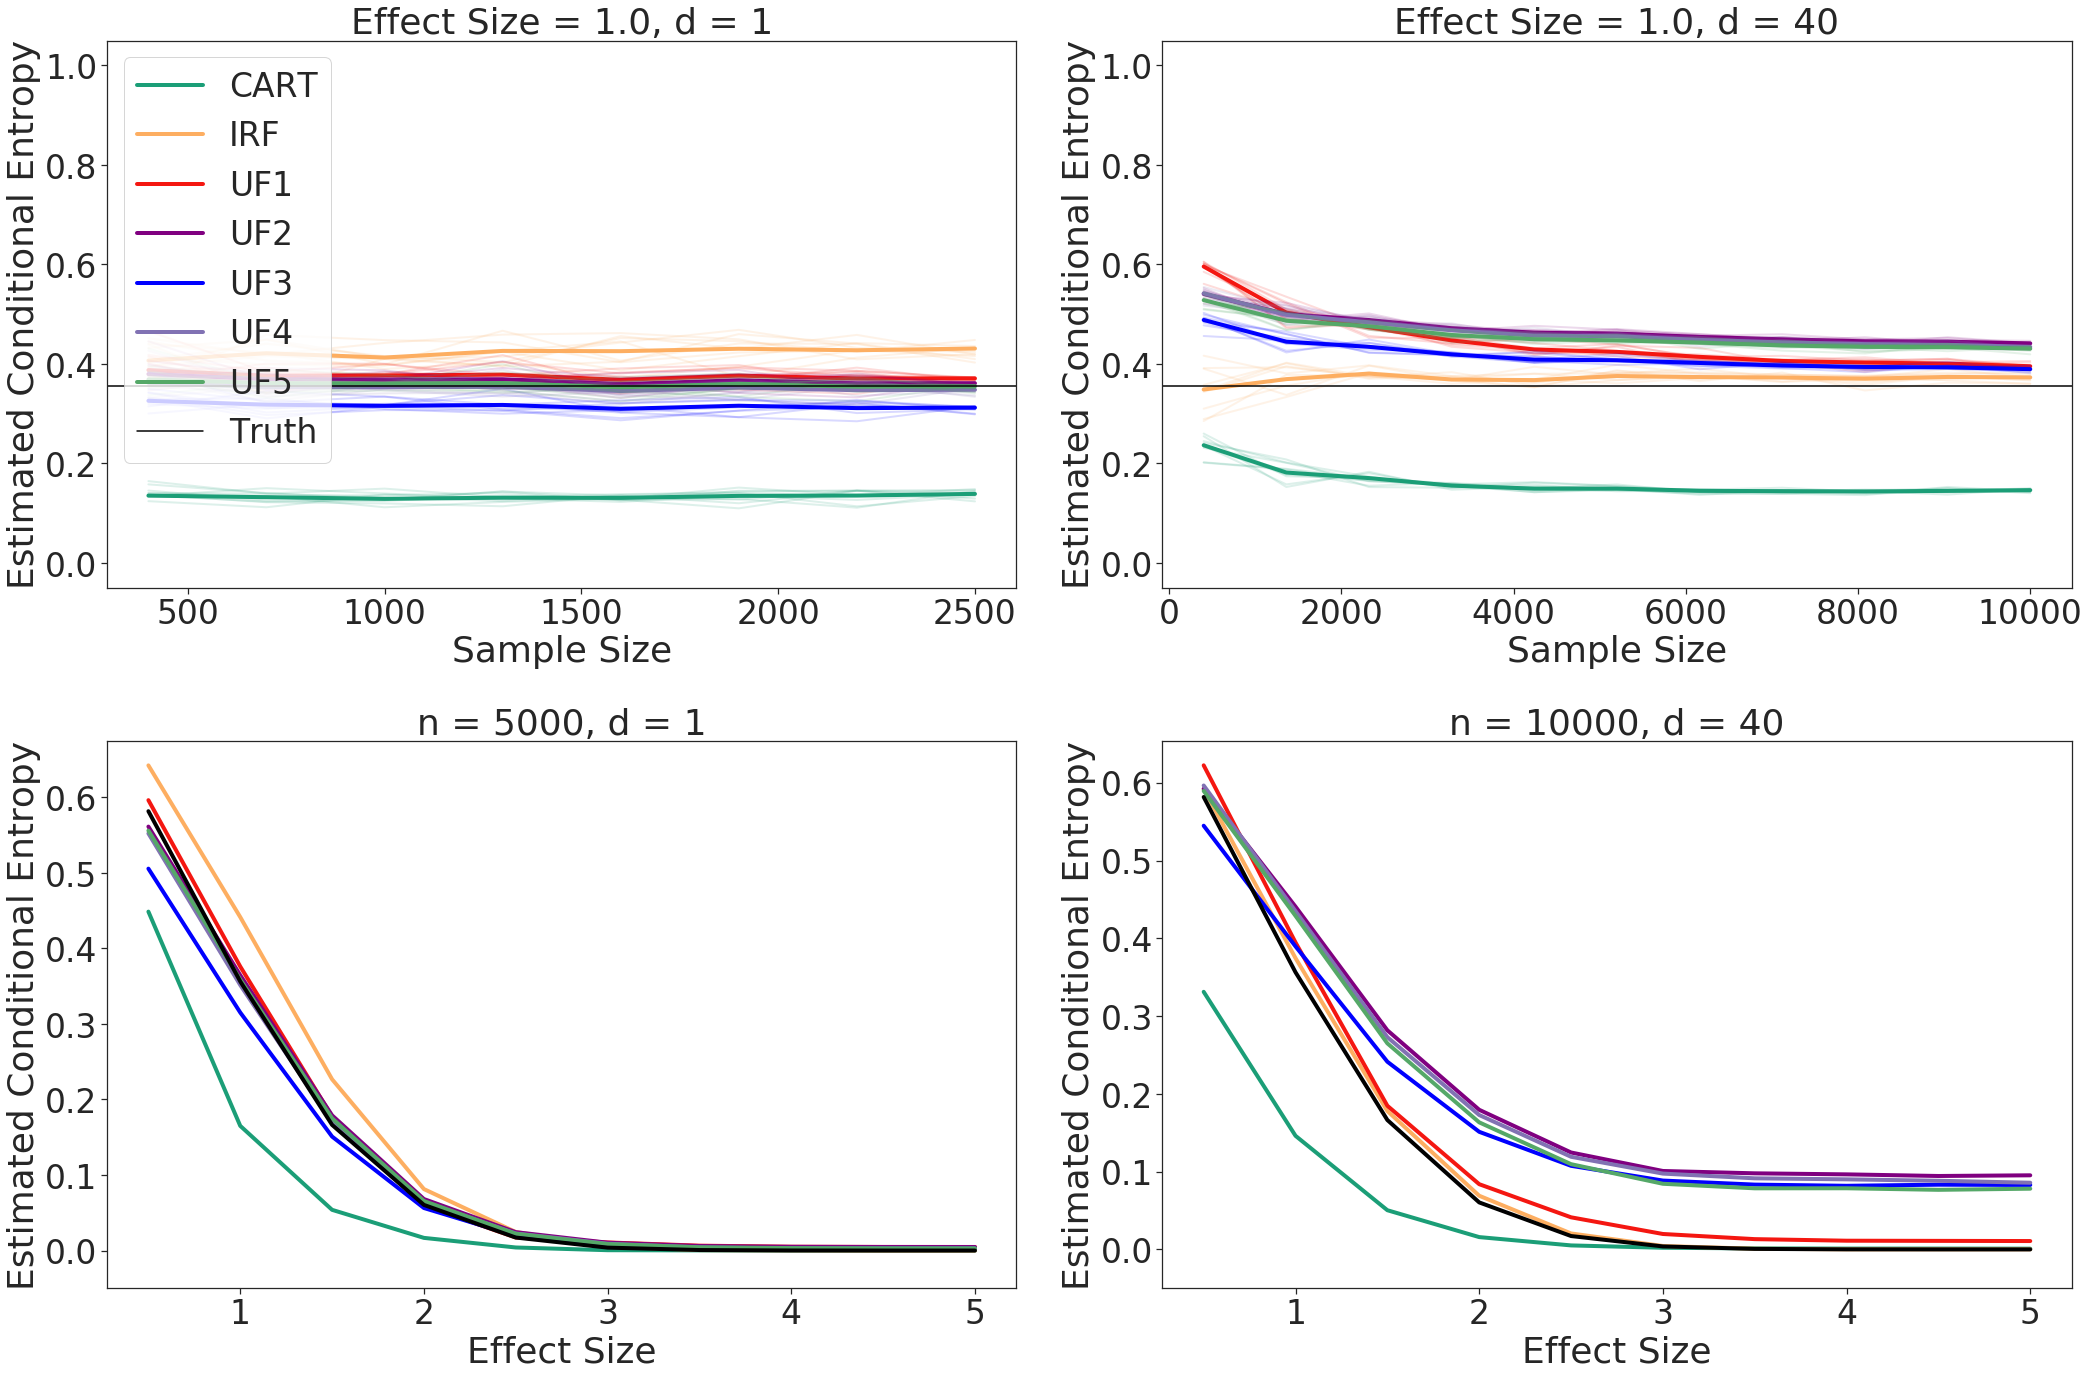

In [23]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)